## 하나의 은닉층으로 평면 데이터 분류

3 주차 프로그래밍 과제에 오신 것을 환영합니다. 은닉층이 있는 첫 번째 신경망을 구축 할 때입니다. 이 모델과 로지스틱 회귀를 사용하여 구현한 모델 사이에는 큰 차이가 있습니다.

다음 방법들을 배우게 됩니다:

* 단일 은닉층으로 2-클래스 분류 신경망 구현
* tanh 와 같은 비선형 활성화 함수가 있는 유닛 사용
* 교차 엔트로피 (cross-entropy)손실 계산
* 순방향 및 역방향 전파 구현

### 1. 패키지

먼저 이 과제 중에 필요한 모든 패키지를 가져 오겠습니다.

* numpy는 Python을 사용한 과학 컴퓨팅의 기본 패키지입니다.
* sklearn은 데이터 마이닝 및 데이터 분석을 위한 간단하고 효율적인 도구를 제공합니다.
* matplotlib는 Python에서 그래프를 그리기 위한 라이브러리입니다.
* testCases는 기능의 정확성을 평가하기 위한 몇 가지 테스트 예제를 제공합니다.
* planar_utils는 이 과제에 사용되는 다양한 유용한 기능을 제공합니다.

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

### 2. 데이터 세트
먼저 작업할 데이터 세트를 가져옵니다. 다음 코드는 "flower" 2-클래스 데이터 세트를 변수 X 및 Y에 로드합니다.

In [2]:
X, Y = load_planar_dataset()
y = Y.reshape(Y.shape[1],)

matplotlib를 사용하여 데이터 세트를 시각화합니다. 데이터는 빨간색(레이블 y = 0)과 파란색 (y = 1) 점이 있는 "꽃"처럼 보입니다. 목표는 이 데이터에 맞는 모델을 만드는 것입니다. 즉, 분류기가 영역을 빨간색 또는 파란색으로 정의하기를 원합니다.

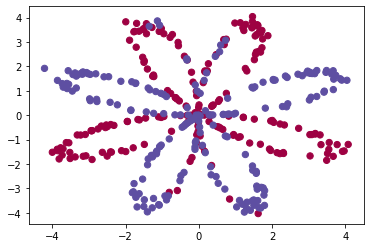

In [3]:
# Visualize the data:
plt.scatter(X[0,:], X[1,:], c=y, s=40, cmap=plt.cm.Spectral)

당신은 다음을 확인합니다.:

- 특성 (x1, x2)을 포함하는 numpy-array (행렬) X
- 레이블 (red : 0, blue : 1)을 포함하는 numpy-array (벡터) Y.

먼저 데이터가 어떤 것인지 더 잘 이해해 보도록 하겠습니다.

**(1) 연습 문제** : 몇 개의 훈련 예제가 있습니까? 또한 변수 X와 Y의 모양은 무엇입니까?

**힌트** : numpy 배열의 모양을 어떻게 얻습니까? ([도움](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html))

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = 
shape_Y =  
m =                        # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:30%">
  <tr>
      <td><b>shape of X </b> : </td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td><b>shape of Y </b> : </td>
    <td>(1, 400) </td> 
  </tr>
  <tr>
    <td><b> m </b> : </td>
    <td> 400 </td> 
  </tr>
</table>

### 3. 단순 로지스틱 회귀
전체 신경망을 구축하기 전에 먼저 이 문제에 대해 로지스틱 회귀가 어떻게 수행되는지 살펴 보겠습니다. 이를 위해 sklearn의 내장 함수를 사용할 수 있습니다. 아래 코드를 실행하여 데이터 세트에서 로지스틱 회귀 분류기를 학습시킵니다.

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(cv=5);
clf.fit(X.T, y.T);

이제 이러한 모델의 결정 경계를 플로팅 할 수 있습니다. 아래 코드를 실행하십시오.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


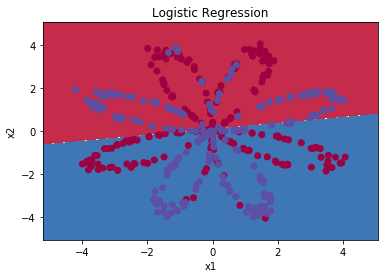

In [6]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:
<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
</table>

**해석** : 데이터 세트는 선형으로 분리 할 수 없으므로 로지스틱 회귀가 제대로 수행되지 않습니다. 신경망이 더 잘할 수 있기를 바랍니다. 지금 시도해 봅시다!

### 4. 신경망 모델
로지스틱 회귀는 "꽃 데이터 세트"에서 제대로 작동하지 않았습니다. 단일 은닉층으로 신경망을 훈련 시키려고 합니다.

다음은 모델입니다.

<img src="./images/classification_kiank.png" width="500">

**수학적으로**:

한 훈련 예제 $x^{(i)}$에 대하여:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$

$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$

$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} \gt 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

모든 예에 대한 예측이 주어지면 비용 $J$를 다음과 같이 계산할 수도 있습니다 : 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large \right) \small \tag{6}$$


**참고** : 신경망을 구축하는 일반적인 방법은 다음과 같습니다.

1. 신경망 구조를 정의합니다 (입력 단위 수, 은닉 단위 수 등).
2. 모델의 매개 변수 초기화
3. 루프 :
     - 순방향 전파 구현
     - 손실 계산
     - 기울기를 얻기 위해 역전파 구현
     - 업데이트 매개 변수 (경사하강법)

1-3 단계를 계산하기 위해 도우미 함수를 구현한 다음 nn_model( )이라고 하는 하나의 함수로 병합하는 경우가 많습니다. nn_model( )을 빌드하고 올바른 매개 변수를 배웠으면 새 데이터에 대한 예측을 할 수 있습니다.
 
#### 4.1. 신경망 구조 정의

**(2) 연습문제** : 세 가지 변수를 정의하십시오.
- n_x : 입력 레이어의 크기
- n_h : 히든 레이어의 크기 (4로 설정)
- n_y : 출력 레이어의 크기

**힌트** : X와 Y의 모양을 사용하여 n_x와 n_y를 찾으십시오. 또한 히든 레이어 크기를 4로 하드 코딩하십시오.

In [7]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x =    # size of input layer
    n_h =  
    n_y =    # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * X의 크기인 input size 는 X.shape[0] 으로 얻을 수 있습니다.

**Expected Output** (이것은 네트워크에 사용할 크기가 아니라 방금 코딩 한 함수를 평가하는 데 사용됩니다.).

<table style="width:20%">
  <tr>
    <td><b>n_x </b> : </td>
    <td> 5 </td> 
  </tr>
  <tr>
    <td><b>n_h </b> : </td>
    <td> 4 </td> 
  </tr>
  <tr>
    <td><b>n_y </b> : </td>
    <td> 2 </td> 
  </tr>
</table>

#### 4.2. 모델의 매개변수 초기화

**(3) 연습문제** : initialize_parameters() 함수를 구현합니다.

**방법**:

* 매개 변수의 크기가 올바른지 확인하십시오. 필요한 경우 위의 신경망 그림을 참조하십시오.
* 임의의 값으로 가중치 행렬을 초기화합니다.
    - 사용 : np.random.randn(a, b) * 0.01을 사용하여 (a, b) 모양의 행렬을 무작위로 초기화합니다.
* 바이어스 벡터를 0으로 초기화합니다.
    - 사용 : np.zeros((a, b))를 사용하여 (a, b) 모양의 행렬을 0으로 초기화합니다.

In [8]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 =                                         # np.random.randn(?,?) * 0.01
    b1 =                                         # np.zeros((?, ?))
    W2 =  
    b2 =  
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#n_x, n_h, n_y = initialize_parameters_test_case()
n_x, n_h, n_y = 2, 4, 1

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * (n_h,n_x) 크기의 W1을 작은(0~0.01 사이의) 무작위 값으로 초기화하기 위해서는 다음과 같이 합니다.
    ```W1 = np.random.randn((n_h,nx)) * 0.01 ```

**Expected Output**:

<table style="width:90%">
  <tr>
    <td>W1</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  <tr>
    <td>b1</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr> 
  <tr>
    <td>W2</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
</table>

#### 4.3. 루프
**(4) 연습 문제** : forward_propagation( )을 구현하십시오.

**방법 설명**:

* 분류기의 수학적 표현을 위에서 살펴보십시오.
* sigmoid( ) 함수를 사용할 수 있습니다. 노트북에 (planar_utils.py 를 import 하여) 내장되었읍니다.
* np.tanh( ) 함수를 사용할 수 있습니다. numpy 라이브러리의 일부입니다.
* 구현해야하는 단계는 다음과 같습니다.
    - parameters[ ".."]를 사용하여 딕셔너리 "parameters"(initialize_parameters ( )의 출력)에서 각 매개 변수를 검색합니다.
    - 순방향 전파를 구현합니다. $Z^{[1]}, A^{[1]}, Z^{[2]}$ 및 $A^{[2]}$ (학습의 모든 예에 대한 모든 예측의 벡터 세트).
* 역전파에 필요한 값은 "캐시"에 저장됩니다. 캐시는 역전파 함수에 대한 입력으로 제공됩니다.

In [9]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 =  
    b1 = 
    W2 =  
    b2 =  
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 =  
    A1 =  
    Z2 =  
    A2 =  
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']), np.mean(cache['A1']), np.mean(cache['Z2']), np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * dictionary 로 제공되는 parameters 에서 W1 key에 해당하는 value를 얻기 위해서는 다음과 같이 합니다. ``` W1 = parameters['W1'] ```
 * W1 * X  연산은 np.dot(W1,X) 로 수행하면 됩니다. 

**Expected Output**:
<table style="width:100%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

이제 모든 예제에 대해 $ a^{[2](i)} $를 포함하는 $ A^{[2]} $ (Python 변수 "A2"에서)를 계산 했으므로 다음과 같이 비용 함수를 계산할 수 있습니다. :

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**(5) 연습 문제** : 비용 $J$의 값을 계산하기 위해 compute_cost( )를 구현합니다.

**방법**:

* 크로스-엔트로피 손실을 구현하는 방법에는 여러 가지가 있습니다. 도움을 주기 위해 $- \sum\limits_{i=0}^{m} y^{(i)}\log(a^{[2](i)})$를 구현한 방법을 알려드립니다.
```
    logprobs = np.multiply(np.log(A2), Y)
    cost = -np.sum(logprobs) # for 루프를 사용할 필요가 없습니다!
```

(np.multiply( ) 다음에 np.sum( ) 또는 직접 np.dot( )를 사용할 수 있습니다).
np.multiply 다음에 np.sum을 사용하면 최종 결과는 float 유형 (1,)이 되고 np.dot를 사용하면 결과는 2D numpy 배열 (1,1)이 됩니다. np.squeeze( )를 사용하여 중복 차원을 제거 할 수 있습니다 (단일 부동의 경우 0 차원 배열로 축소됩니다). float( )를 사용하여 배열을 float 유형으로 캐스팅 할 수 있습니다.

In [10]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 1 lines of code)
    logprobs =  
    ### END CODE HERE ###
    
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


**Expected Output**:
<table style="width:50%">
  <tr>
    <td>cost</td>
    <td> 0.693058761... </td> 
  </tr>
</table>

이제 순방향 전파 중에 계산된 캐시를 사용하여 역방향 전파를 구현할 수 있습니다.

**(6) 연습 문제** : backward_propagation( ) 함수를 구현하십시오.

**방법** : 역전파는 일반적으로 딥 러닝에서 가장 어려운(가장 수학적) 부분입니다. 도움을 주기 위해 역전파에 대한 강의 슬라이드가 다시 보여주고 있습니다. 벡터화된 구현을 구축하고 있으므로 이 슬라이드 오른쪽에 있는 6 개의 방정식을 사용하는 것이 좋습니다.

<img src="./images/grad_summary.png" width="600">

**팁** :
dZ1을 계산하려면 $ g^{[1]'} (Z^{[1]}) $를 계산해야 합니다. $g^{[1]}( )$는 tanh 활성화 함수이므로 $ a=g^{[1]}(z) $이면 $ g^{[1]'}(z) = 1- a^2 $. 따라서 (1-np.power(A1, 2))를 사용하여 $ g^{[1]'} (Z^{[1]}) $를 계산할 수 있습니다.

In [11]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 =  
    W2 =  
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 =  
    A2 =  
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 =  
    dW2 =  
    db2 =  
    dZ1 =  
    dW1 =  
    db1 =  
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * ```dZ2 = A2 - Y```
 * ```dW2 = 1/m * np.dot(dZ2,A1.T)```
 * ```db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)```
 * ...

**Expected output**:

<table style="width:80%">
  <tr>
    <td>dW1</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  <tr>
    <td>db1</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  <tr>
    <td>dW2</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  <tr>
    <td>db2</td>
    <td> [[-0.16655712]] </td> 
  </tr>
</table>  

**(7) 연습 문제** : 업데이트 규칙을 구현하십시오. 경사하강법을 사용합니다. (W1, b1, W2, b2)를 업데이트하려면 (dW1, db1, dW2, db2)를 사용해야합니다.

**일반 경사하강법 규칙** : $ \theta = \theta-\alpha \frac{\partial J}{\partial \theta} $ 여기서 $ \alpha $는 학습률이고 $ \theta $는 매개변수를 나타냅니다.

**그림** : 학습률이 좋고(수렴), 학습률이 나쁜(발산) 경사하강법 알고리즘. 이미지 제공 : Adam Harley.

<img src="./images/sgd.gif" width="300">
<img src="./images/sgd_bad.gif" width="300">

In [12]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 =  
    b1 =  
    W2 =  
    b2 =  
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 =  
    db1 =  
    dW2 =  
    db2 =  
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 =  
    b1 =  
    W2 =  
    b2 =  
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * $W = W - \alpha dW$ 는 다음과 같이 구현될 수 있습니다.
    
    ```W = W - alpha * dW```

**Expected Output**:

<table style="width:80%">
  <tr>
    <td>W1</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

#### 4.4. nn_model( )에서 부분 4.1, 4.2 및 4.3 통합

**(8) 연습 문제** : nn_model( )에서 신경망 모델을 빌드하십시오.

**방법** : 신경망 모델은 올바른 순서로 이전 함수들을 사용해야 합니다.

In [13]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    ### START CODE HERE ### (≈ 1 line of code)
    parameters =  
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache =  
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost =  
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads =  
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters =  
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000218
Cost after iteration 2000: 0.000107
Cost after iteration 3000: 0.000071
Cost after iteration 4000: 0.000053
Cost after iteration 5000: 0.000042
Cost after iteration 6000: 0.000035
Cost after iteration 7000: 0.000030
Cost after iteration 8000: 0.000026
Cost after iteration 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[0.20459656]]


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * parameters 초기화는 initialize_parameters() 함수를 사용하여 얻습니다.
 * A2, cache 는 forward_propagation() 함수를 사용하여 얻습니다.
 * cost 는 compute_cost() 함수를 사용하여 얻습니다.
 * grads 는 backward_propagation() 함수를 사용하여 얻습니다.
 * parameters 업데이트는 update_parameters() 함수를 사용하여 수행합니다.

**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        cost after iteration 0
    </td>
    <td> 
        0.692739
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>W1</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>b1</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>W2</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>b2</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

#### 4.5. 예측

**(9) 연습 문제** : 모델을 사용하여 predict( )를 빌드하여 예측하세요. 순방향 전파를 사용하여 결과를 예측합니다.

**알림** : 예측 = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases} 1 & \text{if}\ activation > 0.5 \\ 0 & \text{otherwise} \end{cases}$

예를 들어, 임계 값에 따라 행렬 X의 항목을 0과 1로 설정하려면 다음을 수행합니다. X_new = (X > threshold)

In [14]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache =  
    predictions = A2 > 0.5
    ### END CODE HERE ###
    
    return predictions

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


<details>
    <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
 
 * A2, cache 는 forward_propagation() 함수를 사용하여 얻습니다.
 * prediction 벡터는 A2 의 크기가 0.5 보다 크면 1, 작으면 0 이 되도록 만듭니다.
    

**Expected Output**: 

<table style="width:40%">
  <tr>
    <td>predictions mean</td>
    <td> 0.666666666667 </td> 
  </tr>
</table>

모델을 실행하고 평면형 데이터 세트에서 어떻게 수행되는 지 살펴볼 시간입니다. $n_h$ 히든 유닛의 단일 히든 레이어로 모델을 테스트하려면 다음 코드를 실행하십시오.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219474
Cost after iteration 9000: 0.218612


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

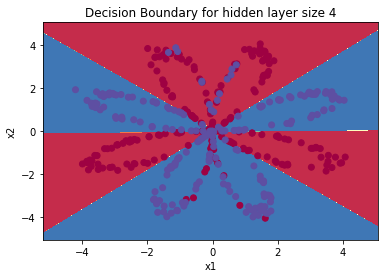

In [20]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>Cost after iteration 9000</td>
    <td> 0.218607 </td> 
  </tr>
</table>

In [16]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Expected Output**: 

<table style="width:25%">
  <tr>
      <td><b>Accuracy</b> : </td>
    <td> 90% </td> 
  </tr>
</table>

로지스틱 회귀에 비해 정확도가 정말 높습니다. 모델은 꽃의 잎 패턴을 배웠습니다! 신경망은 로지스틱 회귀와 달리 매우 비선형적인 결정 경계까지 학습 할 수 있습니다.

이제 몇 가지 은닉 레이어 크기를 사용해 보겠습니다.

#### 4.6. 히든 레이어 크기 조정 (선택 사항 / 비평가 연습문제)
다음 코드를 실행하십시오. 1-2 분이 소요될 수 있습니다. 다양한 은닉층 크기에 대해 모델의 다양한 동작을 관찰 할 수 있습니다.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.25 %


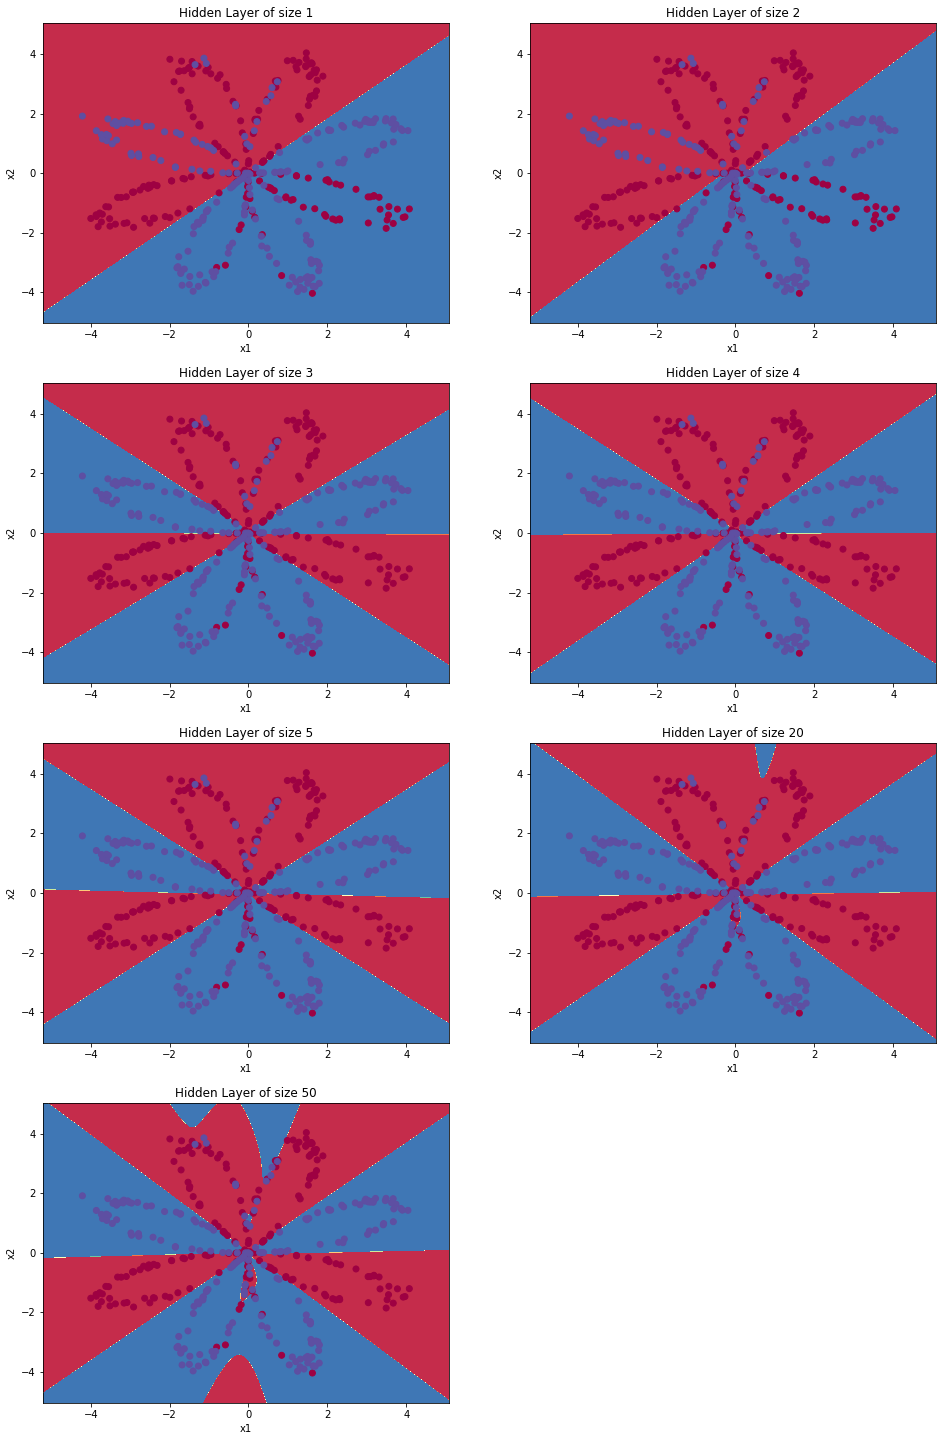

In [21]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**해석**:

더 큰 모델 (숨겨진 단위가 더 많음)은 결국 가장 큰 모델이 데이터를 과적합 할 때까지 훈련 세트에 더 잘 맞을 수 있습니다.
가장 좋은 은닉층 크기는 n_h = 5 정도 인 것 같습니다. 실제로 여기 주변의 값은 눈에 띄는 과적합을 일으키지 않고 데이터에 잘 맞는 것 같습니다.
나중에 과적합 없이 매우 큰 모델 (예 : n_h = 50)을 사용할 수 있는 정규화에 대해서도 배우게 됩니다.

**선택적 질문** :

원하는 경우 탐색 할 수있는 몇 가지 선택적 / 비평가 질문 :

* 시그모이드 활성화 또는 ReLU 활성화에 대한 tanh 활성화를 변경하면 어떻게 됩니까?
* learning_rate로 플레이하십시오. 무슨 일이 나타나나요?
* 데이터 세트를 변경하면 어떻게 되나요? (아래 5 부 참조!)
* 히든 레이어로 완전한 신경망 구축
* 비선형 단위를 잘 활용하십시오.
* 순방향 전파 및 역전파를 구현하고 신경망 훈련
* 과적합을 포함하여 은닉 레이어 크기를 다양화할 때의 영향을 확인하십시오

### 5. 다른 데이터 세트의 성능
원하는 경우 다음 데이터 세트 각각에 대해 전체 노트북 (데이터 세트 부분 제외)을 다시 실행할 수 있습니다.

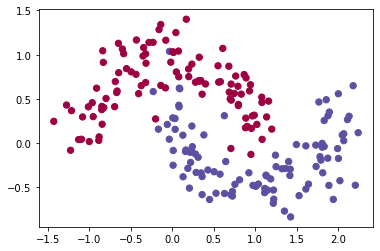

In [18]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
y = Y.reshape(Y.shape[1],)
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral);

**Reference**:

* http://scs.ryerson.ca/~aharley/neural-networks/
* http://cs231n.github.io/neural-networks-case-study/